<a href="https://colab.research.google.com/github/Sonal-kumar1998/ANN_Based_Device_Modelling/blob/main/Charge_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

In [ ]:
model_path = "/content/drive/MyDrive/DDP/AC_Model/AC_Model/drain_charge_model.pth"

In [ ]:
class Model(nn.Module):
    def __init__(self,n_feature):
        super(Model, self).__init__()
        self.lin1 = nn.Linear(n_feature,10)
        self.lin2 = nn.Linear(10,10)
        self.lin3 = nn.Linear(10,5)
        self.lin4 = nn.Linear(5,1)
        #self.lin5 = nn.Linear(10,1)
    def forward(self, x):
        x = torch.tanh(self.lin1(x))
        x = torch.tanh(self.lin2(x))
        x = torch.tanh(self.lin3(x))
        x = self.lin4(x)
        #x = self.lin5(x)
        return x


In [ ]:
model = Model(n_feature = 3)                      # Instanciate the Model 
model.load_state_dict(torch.load(model_path))     # load the Model

<All keys matched successfully>

# ANN Model Charge calculation

In [ ]:
def  plot_charge(gate_volatges):
  outputs = []
  colors = "bgrcmyk"
  for i, gate in enumerate(gate_volatges):
    data_set = pd.read_csv("/content/drive/MyDrive/DDP/AC_Model/Data/AC_Characterisation.csv")
    data_set = data_set.loc[data_set["v(g)"].isin([gate])]
    data_set.sort_values(by="v(d)")
    column_x = ["v(d)",	"v(g)",	"v(b)"]
    input = torch.tensor(data_set[column_x].values , dtype = torch.float32)
    x = data_set["v(d)"]
    output = model(input)
    output = output/(10**15)
    plt.plot(x,output.detach().numpy(),label = "Vgs = "+ str(gate),color = colors[i])
    outputs.append(output.detach().numpy())
  plt.xlabel("Drain Voltage (Vds)")
  plt.ylabel("Drain terminal charge (Qd)")
  plt.title("Qd Vs Vds(ANN)")
  plt.xticks(np.arange(0,9,1))
  plt.grid(b=True, which='both', axis='both')
  plt.legend(loc ="lower right")
  plt.show()
  plt.close()
  return outputs

# Intergral Charge calculation

In [ ]:
def charge(gate_voltages):
  data_set = pd.read_csv("/content/drive/MyDrive/DDP/AC_Model/Data/AC_Characterisation.csv")
  column = ["v(d)",	"v(g)",	"v(b)", "c(d,d)","c(d,g)","c(d,b)"]
  data_set = data_set[column]
  charges = []
  drain_vol = []
  colors = "bgrcmyk"
  for vgs in gate_voltages:
    dataset = data_set.loc[data_set["v(g)"].isin([vgs])]
    dataset.sort_values(by="v(d)")
    qd = [0]
    i = 0
    for drain_cap in dataset["c(d,d)"]:
      i = i + 0.008*drain_cap
      qd.append(i)
    qd.pop()
    charges.append(qd)
    drain_vol = dataset["v(d)"]
  for i,chg in enumerate(charges):
    plt.plot(drain_vol,chg,label = "Vgs = "+ str(gate_voltages[i]),color = colors[i])
  plt.xlabel("Drain Voltage (Vds)")
  plt.ylabel("Drain terminal charge (Qd)")
  plt.title("Qd Vs Vds(TCAD)")
  plt.xticks(np.arange(0,9,1))
  plt.grid(b=True, which='both', axis='both')
  plt.legend(loc ="lower right")
  plt.show()
  plt.close()
  return charges, drain_vol 

# ANN and TCAD Charge Calculation

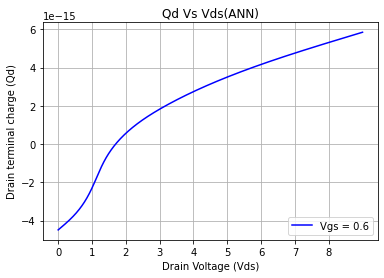

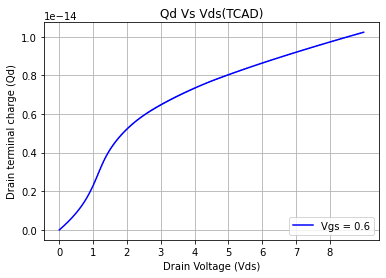

In [ ]:
vgs = [0.6]
#vgs = [0.4,0.6,0.8,1.0]
charge_ANN = plot_charge(vgs)
charge_TCAD, Vds = charge(vgs)

In [ ]:
def offset(charge_ANN,charge_TCAD,drain_voltage,gate_voltages):
  offsets = []
  colors = "bgrcmyk"
  for i in range(len(charge_TCAD)):
    output_TCAD = np.array([charge_TCAD[i]])
    output_TCAD = output_TCAD.T
    X = list(drain_voltage)
    Y = output_TCAD - charge_ANN[i]
    Y = list(Y)

    n = 5
    Y = [Y[i*n]  for i in range(len(Y)//n)]
    X = [X[i*n]  for i in range(len(X)//n)]
    print(len(Y))
    print(len(X))
    plt.plot(X,Y,label = "Vgs = "+ str(gate_voltages[i]),color = colors[i])
  plt.xlabel("Drain Voltage (Vds)")
  plt.ylabel("offset")
  plt.title("offset Vs Vds")
  plt.xticks(np.arange(0,9,1))
  plt.grid(b=True, which='both', axis='both')
  plt.legend(loc ="upper right")
  plt.savefig("offset.png")
  plt.show()
  plt.close()

225
225


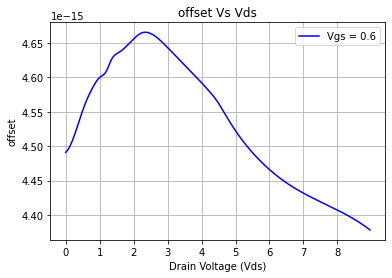

In [ ]:
offset(charge_ANN,charge_TCAD,Vds,vgs)

In [ ]:
def Charge_ANN_TCAD(charge_ANN,charge_TCAD,drain_voltage,gate_voltages):
  offsets = []
  colors = "bgrcmyk"
  for i in range(len(charge_TCAD)):
    output_TCAD = np.array([charge_TCAD[i]])
    output_TCAD = output_TCAD.T
    plt.plot(drain_voltage,output_TCAD,label = "Vgs = "+ str(gate_voltages[i]),color = colors[i])
    plt.plot(drain_voltage,charge_ANN[i],color = colors[i],linestyle=":")
  plt.xlabel("Drain Voltage (Vds)")
  plt.ylabel("Charge(Qd)")
  plt.title("ANN(....) and TCAD(____)")
  plt.xticks(np.arange(0,9,1))
  plt.grid(b=True, which='both', axis='both')
  plt.legend(loc ="lower right")
  plt.savefig("Charge.png")
  plt.show()
  plt.close()

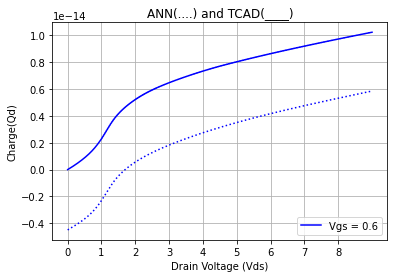

In [ ]:
Charge_ANN_TCAD(charge_ANN,charge_TCAD,Vds,vgs)